In [11]:
import Database_Utils as utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import sklearn.experimental as skexp
import sklearn.impute as skimp
import sklearn.linear_model as sklrm
import sklearn.metrics as mtrcs
import sys
import sklearn.neighbors._base
from sklearn.experimental import enable_iterative_imputer
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
import os

database_dir = os.getcwd()
metadata = pd.read_csv(database_dir+'Metadata.csv',index_col=0)

('OtiraRain', 'Formatted'): 2020                                



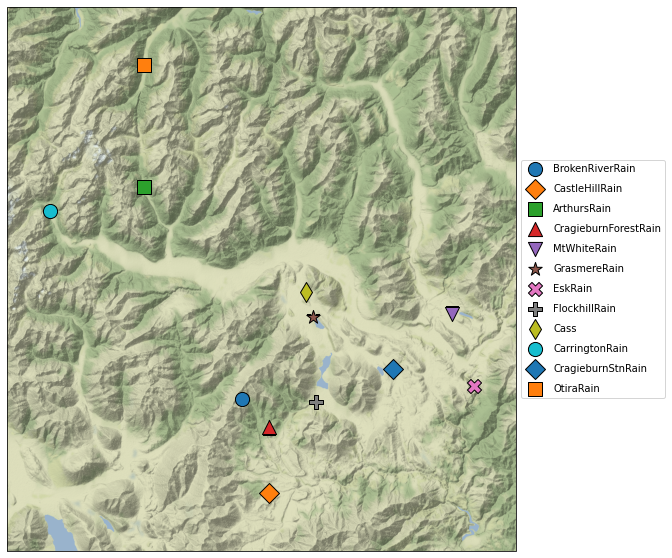

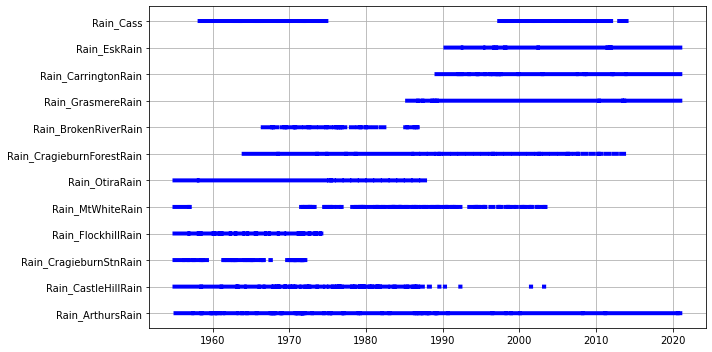

In [9]:
rain_stations = [
            ('ArthursRain','Formatted'),
            ('CarringtonRain','Formatted'),
            ('EskRain','Formatted'),
            ('GrasmereRain','Formatted'),
            ('CragieburnForestRain','Formatted'),
            ('CragieburnForestCombined','Formatted'),
            ('BrokenRiverRain','Formatted'),
            ('BrokenRiverCombined','Formatted'),
            ('Cass','Cleaned'),
            ('CastleHillRain','Formatted'),
            # ('ArthursStoreRain','Formatted'),
            ('CragieburnStnRain','Formatted'),
            ('OldCassRain','Formatted'),
            ('FlockhillRain','Formatted'),
            ('MtWhiteRain','Formatted'),
            ('OtiraRain','Formatted'),
            # ('ClifloArthursRain','Formatted'),
]
# rain_stations = [
#             ('EskRain','Formatted'),
#             ('ArthursRain','Formatted'),
#             ('CarringtonRain','Formatted'),
#             ('GrasmereRain','Formatted'),
#             ('Cass','Cleaned'),]
# rain_stations = [
#             ('ArthursRain','Formatted'),
#             ('GrasmereRain','Formatted'),
#             ('CragieburnForestCombined','Formatted'),
#             ('BrokenRiverCombined','Formatted'),
#             ('ArthursCombined','Formatted')]


params = ['Rain']

# Collect data
rain_data = utils.collect_variables(rain_stations,params, 1955, 2020, 'Daily',database_dir)

# Combine and drop redundant data
rain_data = utils.combine_and_drop(rain_data, 'Cass', 'OldCassRain')
rain_data = utils.combine_and_drop(rain_data, 'BrokenRiverRain', 'BrokenRiverCombined')
rain_data = utils.combine_and_drop(rain_data, 'CragieburnForestRain', 'CragieburnForestCombined')

# This is a hacky little one liner to take mean of each week, but replacing weeks with NaNs as NaN
rain_data = rain_data.fillna(np.inf).groupby(pd.Grouper(freq='1W')).sum().replace(np.inf, np.nan)

# for var in rain_data.columns:
#     rain_data[var]=np.log(1+rain_data[var])

utils.map_stations(rain_data, metadata,map_zoom=12,legend_labelspacing=1, figsize = (15,10),markersize=200,
                   figpath='C:/Users/Callu/Pictures/RainForest_Map.png')
utils.plot_continuity(rain_data,figsize = (10,5),figpath='C:/Users/Callu/Documents/GEOG Project/RainForest_cont.png')

In [3]:
# Imputer for rainfall
imputatorRF = MissForest(n_estimators=400,max_iter =20,max_depth=20, max_features = 7,n_jobs=-1)

# Imputer for is_rain binary dummy variable
dummy_imputer = MissForest(n_estimators=200,max_iter =20,max_depth=10, max_features = 2,n_jobs=-1)


'''Impute whole dataset, no test'''
rf = utils.impute_multiple(rain_data, imputatorRF, 1)
rf.fit_transform(training_data=False)
rf.create_and_impute_dummyvars(training_data=False,dummy_imputer=dummy_imputer)
rf.combine_data_dummy_indicators(training_data=False)
# rf.datasets = rf.datasets_dummied

'''Impute whole dataset, random sample test. PLot evaluation of imputation with and without dummies'''
# rf = utils.impute_multiple(rain_data, imputatorRF, 30)
# rf.split_tests_trains()
# rf.fit_transform(training_data=True)
# rf.create_and_impute_dummyvars(training_data=True,dummy_imputer=dummy_imputer)
# rf.combine_data_dummy_indicators(training_data=True)
# rf.plot_evaluation(imputed_datasets=rf.datasets_dummied,figpath=database_dir+'/Rain_dummy_eval.png')
# rf.plot_evaluation(imputed_datasets=rf.datasets,figpath=database_dir+'/Rain_nodummy_eval.png')

'''Impute with blackout'''
# rf = utils.impute_multiple(rain_data, imputatorRF, 1)
# rf.blackout(holes=[[pd.Timestamp(1972,1,1,0,0,0),pd.Timestamp(1973,1,1,0,0,0)],[pd.Timestamp(2001,1,1,0,0,0),pd.Timestamp(2002,1,1,0,0,0)]], stations=['Cass'])
# rf.fit_transform(training_data=True)
# rf.create_and_impute_dummyvars(training_data=True,dummy_imputer=dummy_imputer)
# rf.combine_data_dummy_indicators(training_data=True)

Imputation 1 of 1 with seed 852012
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Dummy indicator imputation 1 of 1 with seed 852012
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'Impute with blackout'

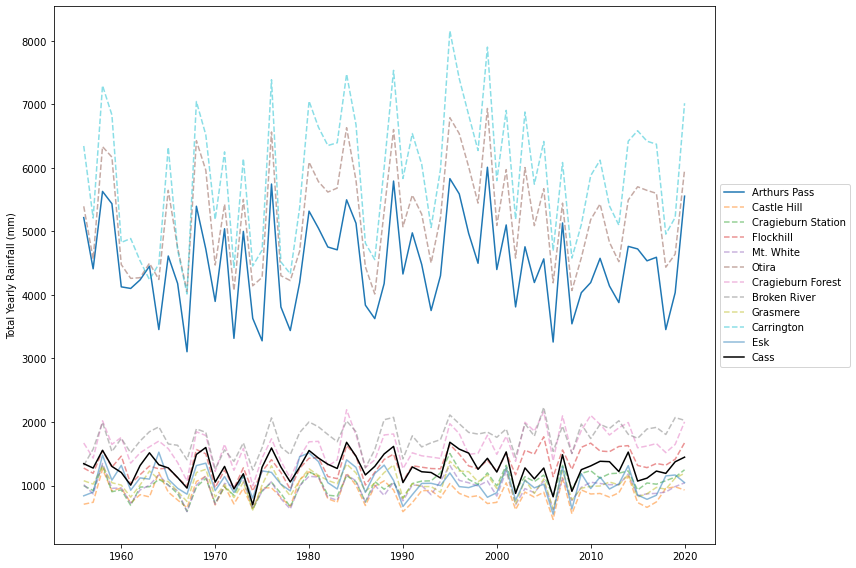

In [5]:
import itertools
yearly_sums = rf.datasets_dummied[0][pd.Timestamp(1955,1,1,0,0,0):pd.Timestamp(2020,1,1,0,0,0)].groupby(pd.Grouper(freq='1Y')).sum()
fig, ax =plt.subplots(1,1,figsize=(12,8))
linestyles = ['-']*1+['dashed']*9+['-']*8
labels = ['Arthurs Pass', 'Castle Hill', 'Cragieburn Station',
       'Flockhill', 'Mt. White', 'Otira',
       'Cragieburn Forest', 'Broken River',
       'Grasmere', 'Carrington', 'Esk',
       'Cass']
alpha = [1]+[0.5]*(len(labels)-1-1)+[1]
colours = itertools.cycle(['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf','#1f77b4']+['k'])

for i,c in enumerate(yearly_sums.columns):
    ax.plot(yearly_sums[c],linestyle= linestyles[i],label=labels[i], alpha=alpha[i],c=next(colours))
    # ax.annotate(xy=(yearly_means[c].index[-1],np.log(1+yearly_means[c])[-1]), xytext=(5,0), textcoords='offset points', text=c, va='center')

# ax.scatter(yearly_means.index,yearly_means.Rain_Cass,label=yearly_means.columns)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel('Total Yearly Rainfall (mm)')
plt.tight_layout()
# plt.savefig('C:/Users/callu/Pictures/rain_by_year.png',dpi=200)

In [8]:
rf.save_imputation(dataset=rf.datasets_dummied[0], out_path = database_dir+'/Imputations/Rainfall_1955_2021.csv')

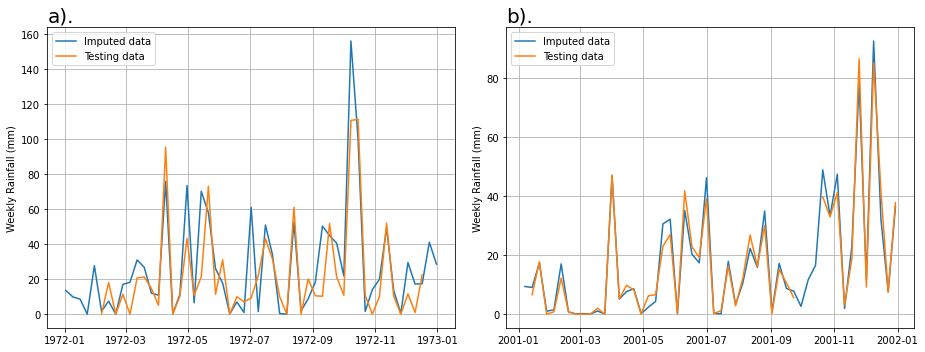

In [48]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(13,5))

ax1.plot(rf.datasets[3].Rain_Cass.loc[pd.Timestamp(1972,1,1,0,0,0):pd.Timestamp(1973,1,1,0,0,0)], label='Imputed data')
ax1.plot(rf.testing_datasets[0].Rain_Cass.loc[pd.Timestamp(1972,1,1,0,0,0):pd.Timestamp(1973,1,1,0,0,0)], label='Testing data')
ax2.plot(rf.datasets[3].Rain_Cass.loc[pd.Timestamp(2001,1,1,0,0,0):pd.Timestamp(2002,1,1,0,0,0)], label='Imputed data')
ax2.plot(rf.testing_datasets[0].Rain_Cass.loc[pd.Timestamp(2001,1,1,0,0,0):pd.Timestamp(2002,1,1,0,0,0)], label='Testing data')
ax2.legend()
ax1.legend()
ax1.set_title('a).',loc='left',size=20)
ax2.set_title('b).',loc='left',size=20)
ax1.grid()
ax2.grid()
ax2.set_ylabel('Weekly Rainfall (mm)')
ax1.set_ylabel('Weekly Rainfall (mm)')
plt.tight_layout()
plt.savefig('C:/Users/callu/Documents/Rain_blackout.png',dpi=250)